In [72]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=16

train_cardiac_total=pd.read_csv("mimic_ca_vital_sign_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_ca_vital_sign_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_ca_baseline_total_v2.csv")

eicu_cardiac_total=pd.read_csv("eicu_total_"+str(T)+"hours.csv")

total_train=21540 #control+event
total_test=5384 #control+event
train_control=21160 #control


var=6
random=32
smote_ratio=1
#near_ratio=0.35
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels
y_test_log=df_test_base['eventV3'].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
#nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total 

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

#print(df_train_base.columns)


timeline: (21540, 96)
baseline: (21540, 70)
timeline: (42320, 16, 6)
baseline: (42320, 70)
label: (42320,)
timeline: (5384, 16, 6)
baseline: (5384, 70)
label: (5384, 1)


In [73]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 16, 6)
(8464, 16, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 16, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 16, 8)             480       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 8)             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 25s - loss: 0.6280 - accuracy: 0.6701 - f1_m: 0.6211 - precision_m: 0.7257 - val_loss: 0.5908 - val_accuracy: 0.6942 - val_f1_m: 0.3706 - val_precision_m: 0.5016
Epoch 3/3
 - 24s - loss: 0.6127 - accuracy: 0.6834 - f1_m: 0.6390 - precision_m: 0.7415 - val_loss: 0.5788 - val_accuracy: 0.7079 - val_f1_m: 0.3886 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 79.96 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 70.3893%
test accuracy = 77.3031%
test error = 1222 out of 5384 examples


In [74]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 1 0 1]


In [75]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4107 1182]
 [  40   55]]
specificity: 0.7765173000567215
sensitivity: 0.5789473684210527
ppv: 0.0444624090541633
npv: 0.9903544731130938


In [76]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 16, 6)
(8464, 16, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 16, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 16, 8)             480       
_________________________________________________________________
dropout_19 (Dropout)         (None, 16, 8)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 25s - loss: 0.7015 - accuracy: 0.4983 - f1_m: 0.4841 - precision_m: 0.4986 - val_loss: 0.6970 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/3
 - 31s - loss: 0.6969 - accuracy: 0.4926 - f1_m: 0.4609 - precision_m: 0.4917 - val_loss: 0.6952 - val_accuracy: 0.5000 - val_f1_m: 0.5013 - val_precision_m: 0.5009
-----------------------------------------------------------------
Training was completed in 86.42 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.0%
test accuracy = 1.7645%
test error = 5289 out of 5384 examples


In [77]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[1 1 1 ... 1 1 1]


In [78]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[   0 5289]
 [   0   95]]
specificity: 0.0
sensitivity: 1.0
ppv: 0.01764487369985141
npv: nan


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  from ipykernel import kernelapp as app


In [79]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 16, 6)
(8464, 16, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 16, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 16, 8)             480       
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 8)             0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 8)             32        
_________________________________________________________________
lstm_23 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 43s - loss: 0.6324 - accuracy: 0.6676 - f1_m: 0.6189 - precision_m: 0.7246 - val_loss: 0.6095 - val_accuracy: 0.6818 - val_f1_m: 0.3583 - val_precision_m: 0.5013
Epoch 3/3
 - 38s - loss: 0.6204 - accuracy: 0.6797 - f1_m: 0.6275 - precision_m: 0.7432 - val_loss: 0.6052 - val_accuracy: 0.6816 - val_f1_m: 0.3288 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 130.94 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 69.0808%
test accuracy = 85.4012%
test error = 786 out of 5384 examples


In [80]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 0 ... 1 0 1]


In [81]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4555  734]
 [  52   43]]
specificity: 0.8612214029117036
sensitivity: 0.45263157894736844
ppv: 0.055341055341055344
npv: 0.9887128283047536


In [82]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 16, 6)
(8464, 16, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 16, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 16, 8)             480       
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 8)             0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 8)             32        
_________________________________________________________________
lstm_26 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 41s - loss: 0.6149 - accuracy: 0.6902 - f1_m: 0.6440 - precision_m: 0.7504 - val_loss: 0.5777 - val_accuracy: 0.7095 - val_f1_m: 0.3696 - val_precision_m: 0.5013
Epoch 3/3
 - 39s - loss: 0.5959 - accuracy: 0.7019 - f1_m: 0.6658 - precision_m: 0.7537 - val_loss: 0.5633 - val_accuracy: 0.7200 - val_f1_m: 0.3942 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 132.27 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.4585%
test accuracy = 77.7675%
test error = 1197 out of 5384 examples


In [83]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[0 0 0 ... 1 0 1]


In [84]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4132 1157]
 [  40   55]]
specificity: 0.7812440915106825
sensitivity: 0.5789473684210527
ppv: 0.04537953795379538
npv: 0.9904122722914669


In [85]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 16, 6)
(8464, 16, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 16, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 16, 8)             480       
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 8)             0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 8)             32        
_________________________________________________________________
lstm_29 (LSTM)               (None, 16, 8)             544       
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 8)             0         
______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 43s - loss: 0.6377 - accuracy: 0.6666 - f1_m: 0.6165 - precision_m: 0.7239 - val_loss: 0.6065 - val_accuracy: 0.6894 - val_f1_m: 0.3579 - val_precision_m: 0.5017
Epoch 3/3
 - 43s - loss: 0.6185 - accuracy: 0.6806 - f1_m: 0.6234 - precision_m: 0.7565 - val_loss: 0.5863 - val_accuracy: 0.6990 - val_f1_m: 0.3485 - val_precision_m: 0.5017
-----------------------------------------------------------------
Training was completed in 138.48 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 69.8754%
test accuracy = 84.2125%
test error = 850 out of 5384 examples


In [86]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 0 0 ... 1 0 1]


In [87]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4491  798]
 [  52   43]]
specificity: 0.8491208167895632
sensitivity: 0.45263157894736844
ppv: 0.05112960760998811
npv: 0.9885538190622937


In [88]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [89]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 1 0 1]


In [90]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[4325  964]
 [  40   55]]
specificity: 0.8177349215352618
sensitivity: 0.5789473684210527
ppv: 0.053974484789008834
npv: 0.8177349215352618


<Figure size 432x288 with 0 Axes>

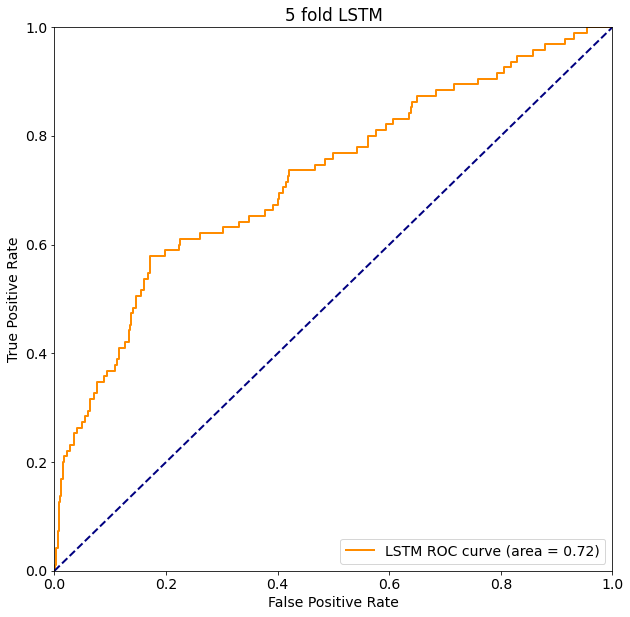

In [91]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [92]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.81
AUC : 0.72
Sensitivity : 0.58
Specificity :0.82
64.94464923401927


In [93]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import model_selection

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest = forest.fit(x_train_base, y_train)

prob_predict_y_validation1 = forest.predict_proba(x_train_base)#给出带有概率值的结果，每个点所有label的概率和为1
prob_predict_y_validation = forest.predict_proba(x_test_base)#给出带有概率值的结果，每个点所有label的概率和为1


y_score = prob_predict_y_validation[:, 1]
# 預測
predict_train_rf = prob_predict_y_validation1[:, 1]

test_y_predicted = forest.predict(x_test_base)

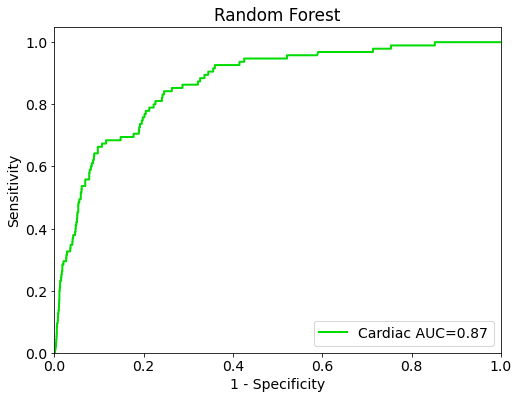

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Random Forest')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [95]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(total_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

Accuracy  = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])   

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Accuracy : %0.2f' %Accuracy)  #Accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)



Confusion Matrix : 
 [[4976  313]
 [  46   49]]
Accuracy : 0.93
AUC : 0.87
Sensitivity : 0.52
Specificity :0.94


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(x_train_base, y_train)

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [97]:
predict_train_logistic_result = logreg.predict_proba(x_train_base)

predict_train_logistic = predict_train_logistic_result[:, 1]

logreg_test_y_predicted = logreg.predict_proba(x_test_base)

log_y_score = logreg_test_y_predicted[:, 1]

predict_test=[]
for i in range(log_y_score.shape[0]): 
    if log_y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_log,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.799777
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4231,1058
1,20,75


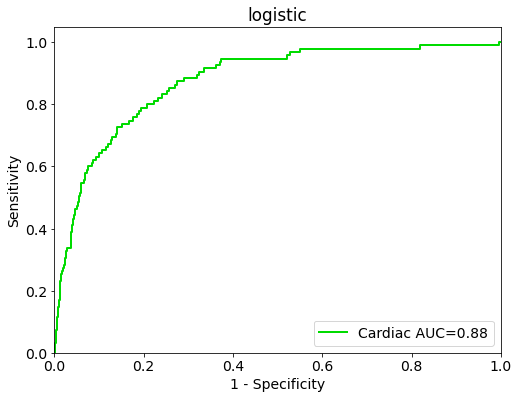

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('logistic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [99]:
print(predict_train_logistic)
print(predict_train_lstm)

stacking=np.append(predict_train_logistic, predict_train_lstm)
x_train_stacking=np.array(stacking).reshape(x_train_lstm.shape[0],2, order='F') #轉維

from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm = svm.SVC(kernel='linear',probability=True)
svm.fit(x_train_stacking,y_train)

print(x_train_stacking.shape)
print(y_train.shape)

print(log_y_score.shape)#logistic test 機率
print(y_pred.shape)#lstm test 機率 
print(y_score.shape)#Rf test 機率

stacking_test=np.append(y_pred, log_y_score)
x_test_stacking=np.array(stacking_test).reshape(total_test,2, order='F') #轉維


[0.14063802 0.03412005 0.47621695 ... 0.64044788 0.85612376 0.2473725 ]
[0.33948848 0.5122073  0.36775076 ... 0.40583372 0.48910347 0.68863547]
(42320, 2)
(42320,)
(5384,)
(5384,)
(5384,)


In [100]:
predict=svm.predict(x_test_stacking)
predict_pro_stacking=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_test, predict)
precision  = metrics.precision_score(y_test, predict)

print(accuracy)
print(precision)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_stacking=predict_pro_stacking[:,1:2]

#################92個test ca 輸出#####################
#test=pd.DataFrame(predict[4689:])
#test.to_csv('24hour_ca.csv', index=False)
####################################### predict_pro_stacking

0.8107355126300149
0.07142857142857142


In [101]:
predict_test_stacking=[]
for i in range(predict_pro_stacking.shape[0]): 
    if predict_pro_stacking[i]>0.5:
        predict_test_stacking.append(1)
    else:
        predict_test_stacking.append(0)
predict_test_stacking = np.array(predict_test_stacking)


In [102]:
pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_stacking)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)
flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro_stacking[i]>0.5:
            total_predict=total_predict+predict_pro_stacking[i]
            flag=flag+1
print(flag)  #score

print(y_test_1D)

Confusion Matrix : 
 [[4347  942]
 [  19   76]]
specificity: 0.8218944980147476
sensitivity: 0.8
ppv: 0.07465618860510806
npv: 0.8218944980147476
1018
[0 0 0 ... 1 1 1]


In [103]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, predict_pro_stacking)
print(brier_score)

0.12625354660775517


[[0.58423684]
 [0.51896204]
 [0.08214865]
 ...
 [0.91158301]
 [0.82677028]
 [0.91507461]]


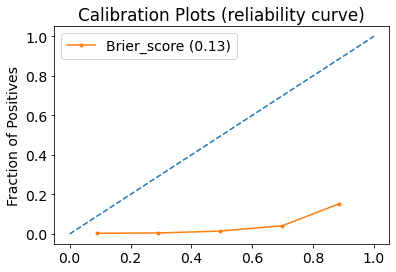

In [104]:
print(predict_pro_stacking)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, predict_pro_stacking)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (reliability curve)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

<Figure size 432x288 with 0 Axes>

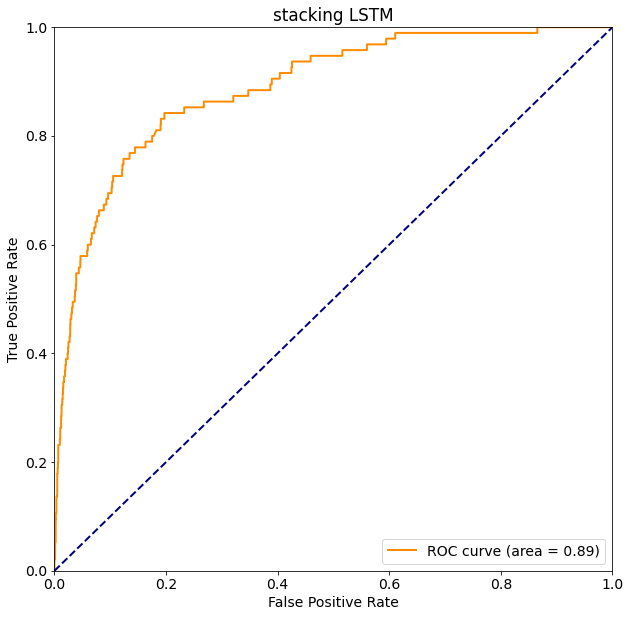

In [105]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, predict_pro_stacking) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM')
plt.legend(loc="lower right")

plt.show()

In [106]:
print('Accuracy : %0.2f' %accuracy)  #Accuracy
print('precision : %0.2f' %precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

Accuracy : 0.81
precision : 0.07
AUC : 0.89
Sensitivity : 0.80
Specificity :0.82
[73.20275697]


In [107]:
predict_pro_stacking

array([[0.58423684],
       [0.51896204],
       [0.08214865],
       ...,
       [0.91158301],
       [0.82677028],
       [0.91507461]])

In [108]:
predict_pro_stacking_ca=pd.DataFrame(predict_pro_stacking)
#predict_pro_stacking_ca.to_csv('predict_pro_stacking_ca.csv', index=False)

In [109]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

y_validation=df_eicu['user']

x_lstm_validation=eicu_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation=np.array(x_lstm_validation).reshape(10665,T,var) #轉三維  total 

print(x_lstm_validation.shape)
print(y_validation.shape)

(10665, 16, 6)
(10665,)


-----------------------------------------------------------------
test accuracy = 75.0305%
test error = 2663 out of 10665 examples


<Figure size 432x288 with 0 Axes>

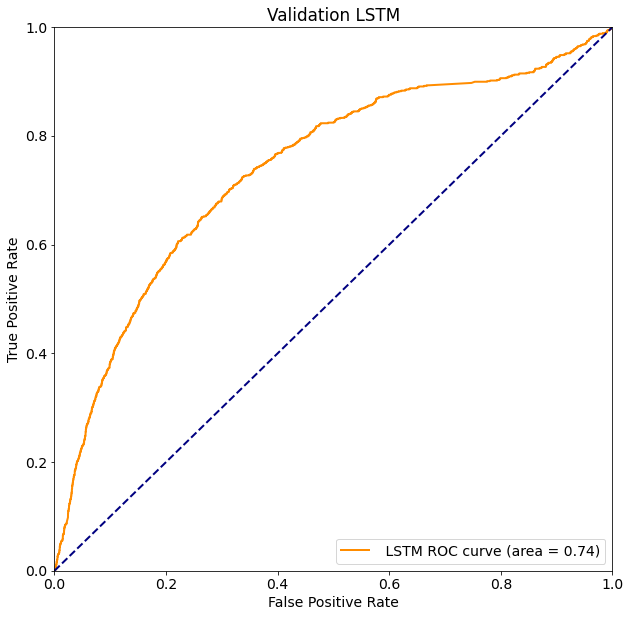

In [110]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_1) * 10665)} out of {10665} examples')

validation_pred1= model_1.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 8.5982%
test error = 9748 out of 10665 examples


<Figure size 432x288 with 0 Axes>

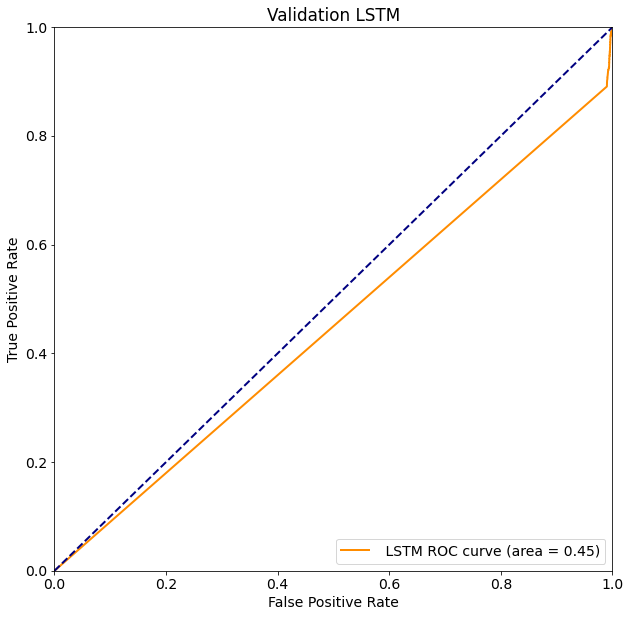

In [111]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_2) * 10665)} out of {10665} examples')

validation_pred2= model_2.predict(x_lstm_validation)


# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 83.9662%
test error = 1710 out of 10665 examples


<Figure size 432x288 with 0 Axes>

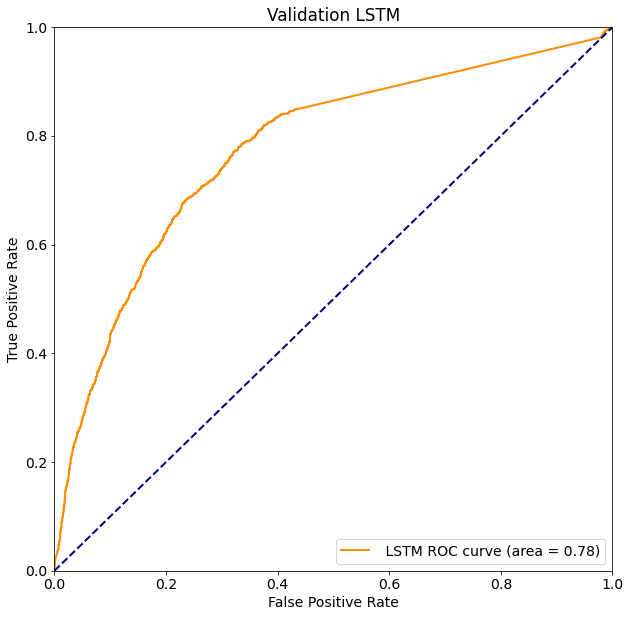

In [112]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_3) * 10665)} out of {10665} examples')

validation_pred3= model_3.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 65.4571%
test error = 3684 out of 10665 examples


<Figure size 432x288 with 0 Axes>

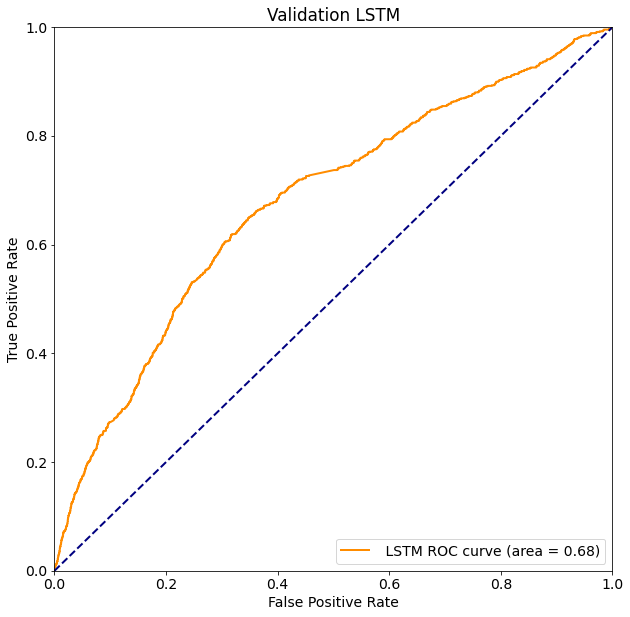

In [113]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_4) * 10665)} out of {10665} examples')

validation_pred4= model_4.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 77.112%
test error = 2441 out of 10665 examples


<Figure size 432x288 with 0 Axes>

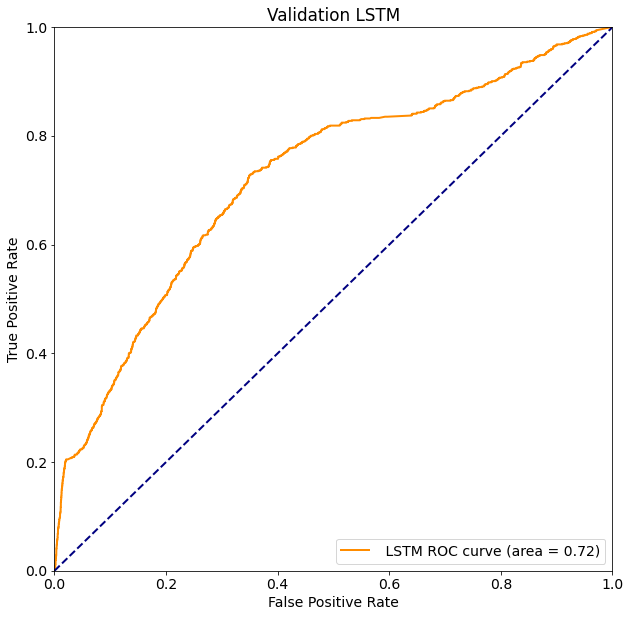

In [114]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * 10665)} out of {10665} examples')

validation_pred5= model_5.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [115]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

validation_pred_old=np.array(pred_temp).reshape(10665,5, order='F') #轉維

validation_pred_old= np.mean(validation_pred_old, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

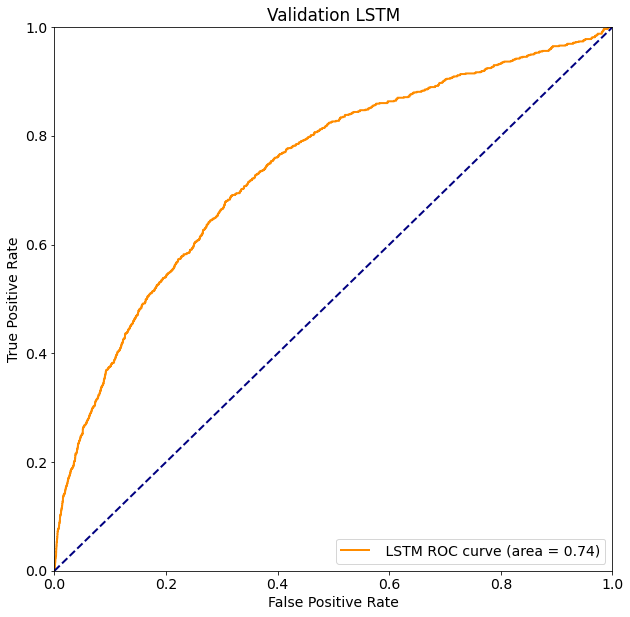

In [116]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [117]:
y_validation_1D=np.array(y_validation).reshape(10665)

predict_test=[]
for i in range(validation_pred_old.shape[0]): 
    if validation_pred_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[7448 2300]
 [ 383  534]]


In [118]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation_old=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation_old=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_validation_old=minmax_scale.fit_transform(x_validation_old)

#predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
#y_score_validation_old = predict_validation[:, 1] #RF

predict_validation_old = logreg.predict_proba(x_validation_old)
y_score_validation_old = predict_validation_old[:, 1]

predict_test=[]
for i in range(y_score_validation_old.shape[0]): 
    if y_score_validation_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation_old).reshape(10665)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[8118 1630]
 [ 478  439]]


In [119]:
stacking_validation_test=np.append(validation_pred_old, y_score_validation_old)
x_test_stacking=np.array(stacking_validation_test).reshape(10665,2, order='F') #轉維

predict=svm.predict(x_test_stacking)
predict_pro_old=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_validation_old, predict)
precision  = metrics.precision_score(y_validation_old, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_old=predict_pro_old[:,1:2]

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro_old[i]>0.5:
            total_predict=total_predict+predict_pro_old[i]
            flag=flag+1
#print(flag)  #score



Confusion Matrix : 
 [[7926 1822]
 [ 383  534]]
specificity: 0.8130898645876077
sensitivity: 0.5823336968375137
ppv: 0.2266553480475382
npv: 0.9539054037790348


<Figure size 432x288 with 0 Axes>

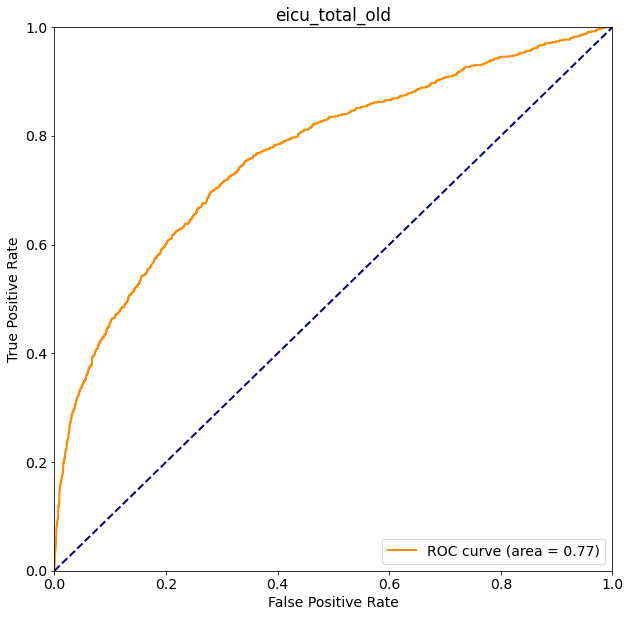

In [120]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation_old, predict_pro_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_old')
plt.legend(loc="lower right")

plt.show()

predict_pro_old =pd.DataFrame(predict_pro_old)
#predict_pro_old.to_csv('predict.csv', index=False)

In [121]:
test_acc=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
print('Accuracy : %0.2f' %test_acc)  #Accuracy
print('precision : %0.2f' %test_precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
print('ppv : %0.2f' % ppv )
print('npv :%0.2f' % npv)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
#print(total_predict/flag*100)  #score

Accuracy : 0.79
precision : 0.02
AUC : 0.77
Sensitivity : 0.58
Specificity :0.81
ppv : 0.23
npv :0.95


In [122]:
df_eicu_new=pd.read_csv("baseline_eicu_version2.csv")  #baseline 
eicu_cardiac_total_new=pd.read_csv("eicu_version2_"+str(T)+"hours.csv") #vital sign

y_validation=df_eicu_new['user']

x_lstm_validation_new=eicu_cardiac_total_new[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation_new=np.array(x_lstm_validation_new).reshape(10049,T,var) #轉三維  total 

print(x_lstm_validation_new.shape)
print(y_validation.shape)

(10049, 16, 6)
(10049,)


-----------------------------------------------------------------
test accuracy = 76.2066%
test error = 2391 out of 10049 examples


<Figure size 432x288 with 0 Axes>

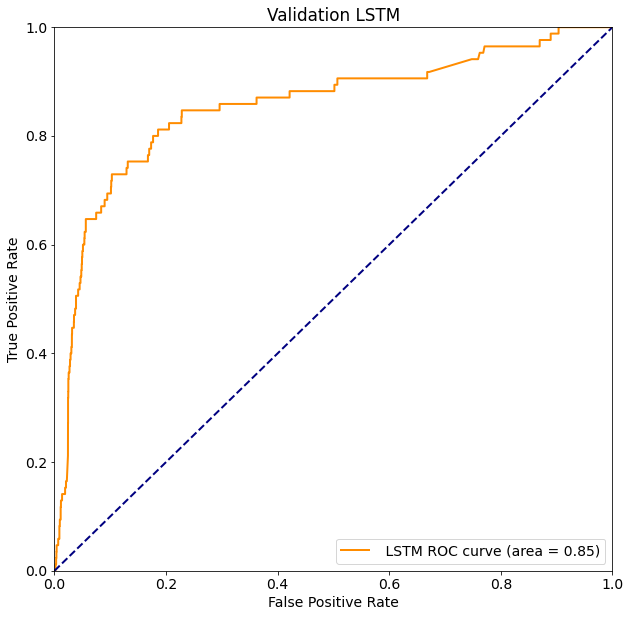

In [123]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_1) * 10049)} out of {10049} examples')

validation_pred1= model_1.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 0.8658%
test error = 9962 out of 10049 examples


<Figure size 432x288 with 0 Axes>

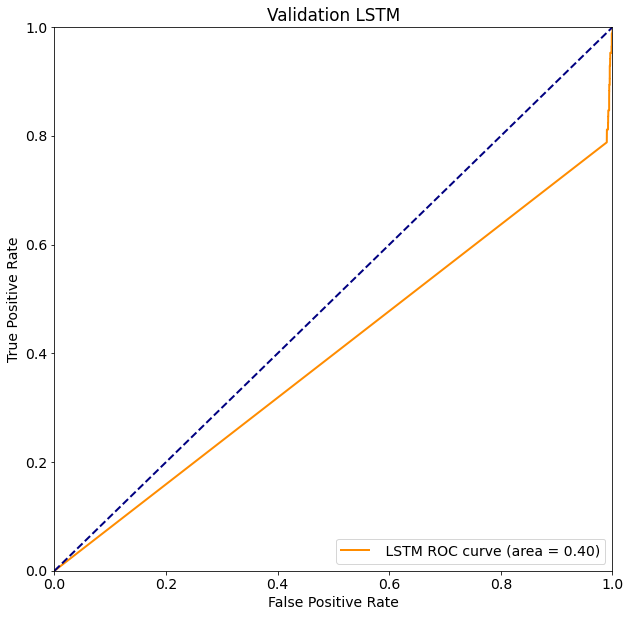

In [124]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_2) * 10049)} out of {10049} examples')

validation_pred2= model_2.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 86.9738%
test error = 1309 out of 10049 examples


<Figure size 432x288 with 0 Axes>

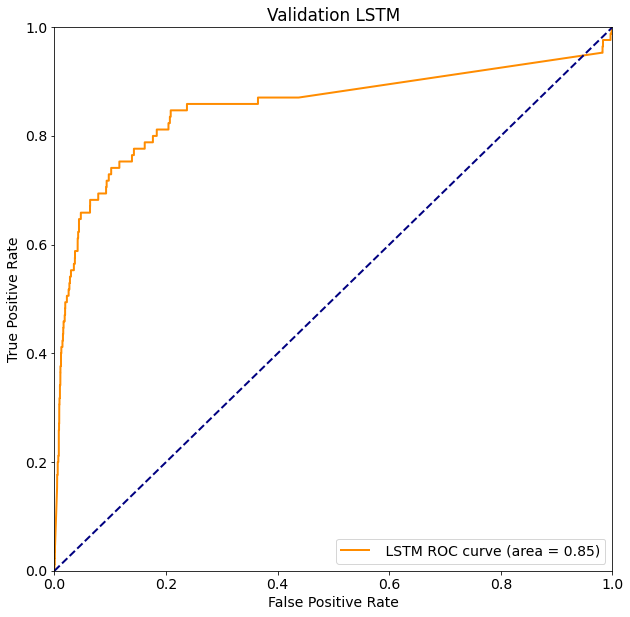

In [125]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_3) * 10049)} out of {10049} examples')

validation_pred3= model_3.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 65.5389%
test error = 3463 out of 10049 examples


<Figure size 432x288 with 0 Axes>

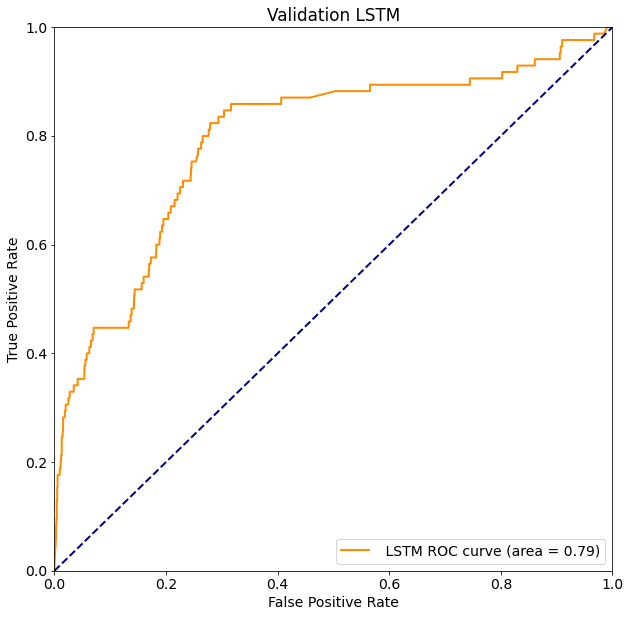

In [126]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_4) * 10049)} out of {10049} examples')

validation_pred4= model_4.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 79.3412%
test error = 2076 out of 10049 examples


<Figure size 432x288 with 0 Axes>

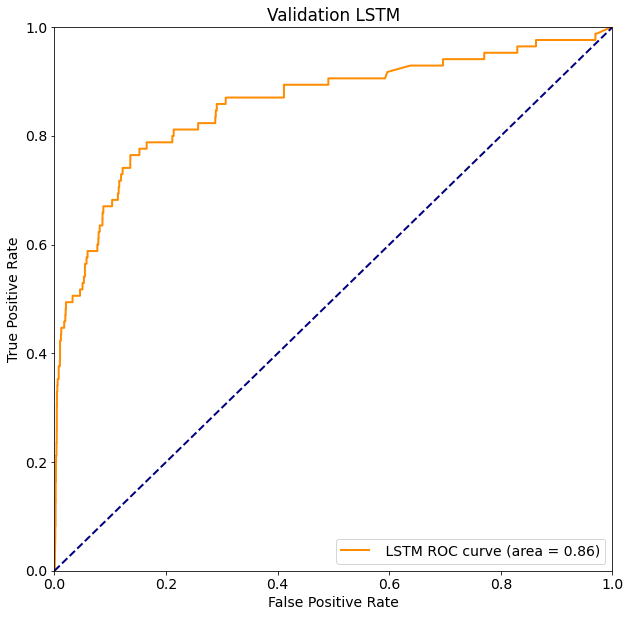

In [127]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation_new,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * 10049)} out of {10049} examples')

validation_pred5= model_5.predict(x_lstm_validation_new)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [128]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

validation_pred=np.array(pred_temp).reshape(10049,5, order='F') #轉維

validation_pred= np.mean(validation_pred, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

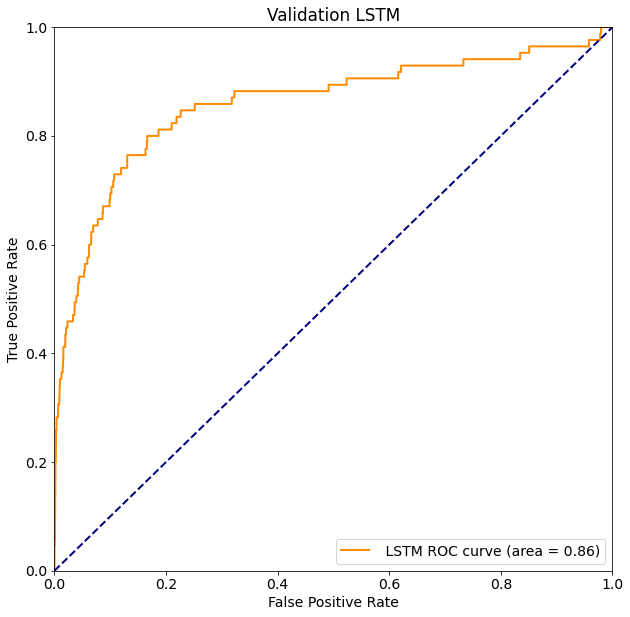

In [129]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [130]:
y_validation_1D=np.array(y_validation).reshape(10049)

predict_test=[]
for i in range(validation_pred.shape[0]): 
    if validation_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[7598 2366]
 [  13   72]]


In [131]:
df_eicu=pd.read_csv("baseline_eicu_version2.csv")  #baseline 

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_validation=minmax_scale.fit_transform(x_validation)

#predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
#y_score_validation = predict_validation[:, 1] #RF

predict_validation = logreg.predict_proba(x_validation)
y_score_validation = predict_validation[:, 1]

predict_test=[]
for i in range(y_score_validation.shape[0]): 
    if y_score_validation[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation).reshape(10049)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR



Confusion Matrix : 
 [[8244 1720]
 [  49   36]]


In [132]:
y_test_1D.shape

(10049,)

In [133]:
predict_test.shape

(10049,)

In [134]:
stacking_validation_test=np.append(validation_pred, y_score_validation)
x_test_stacking=np.array(stacking_validation_test).reshape(10049,2, order='F') #轉維

predict=svm.predict(x_test_stacking)
predict_pro=svm.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_validation, predict)
precision  = metrics.precision_score(y_validation, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro=predict_pro[:,1:2]

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro[i]>0.5:
            total_predict=total_predict+predict_pro[i]
            flag=flag+1
#print(flag)  #score



Confusion Matrix : 
 [[8049 1915]
 [  28   57]]
specificity: 0.8078081091930951
sensitivity: 0.6705882352941176
ppv: 0.028904665314401622
npv: 0.9965333663488919


<Figure size 432x288 with 0 Axes>

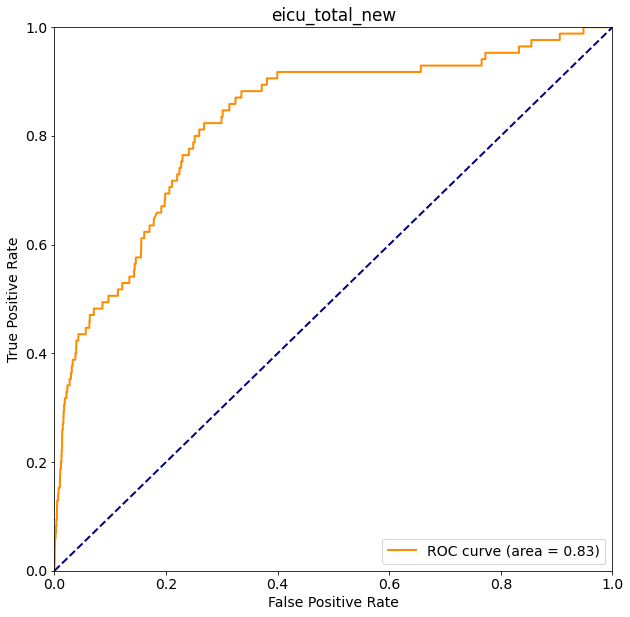

In [135]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, predict_pro) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('eicu_total_new')
plt.legend(loc="lower right")

plt.show()

predict_pro =pd.DataFrame(predict_pro)
predict_pro.to_csv('predict.csv', index=False)

In [136]:
test_acc=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
print('Accuracy : %0.2f' %test_acc)  #Accuracy
print('precision : %0.2f' %test_precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
print('ppv : %0.2f' % ppv )
print('npv :%0.2f' % npv)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
#print(total_predict/flag*100)  #score

Accuracy : 0.81
precision : 0.02
AUC : 0.83
Sensitivity : 0.67
Specificity :0.81
ppv : 0.03
npv :1.00


In [137]:
predict_cxr=pd.read_csv("neur_test_all_patients.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)
#print(y_predict_cxr)
#print(y_predict_cxr.size)

for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

5384


In [138]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


Confusion Matrix : 
 [[3866 1423]
 [  13   82]]
Sensitivity : 0.86
Specificity :0.73


<Figure size 432x288 with 0 Axes>

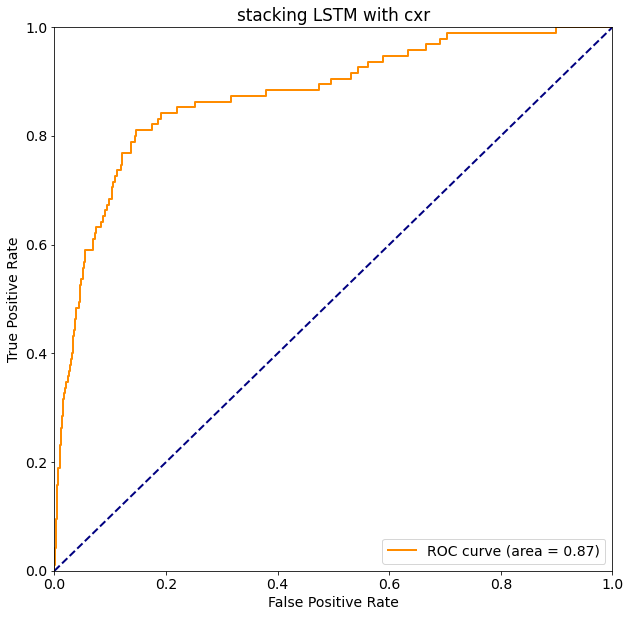

In [139]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [140]:
predict_cxr=pd.read_csv("neur_test_all_patients1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)
#print(y_predict_cxr)
#print(y_predict_cxr.size)

for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

5384


In [141]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


Confusion Matrix : 
 [[4265 1024]
 [  17   78]]
Sensitivity : 0.82
Specificity :0.81


<Figure size 432x288 with 0 Axes>

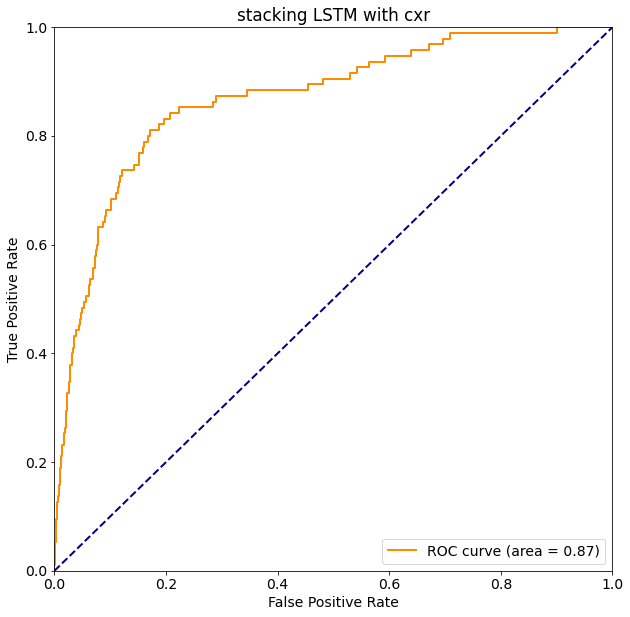

In [142]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [143]:
predict_cxr=pd.read_csv("neur_test_all_patients1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)
#print(y_predict_cxr)
#print(y_predict_cxr.size)

for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

5384


In [144]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)


Confusion Matrix : 
 [[4265 1024]
 [  17   78]]
Sensitivity : 0.82
Specificity :0.81


<Figure size 432x288 with 0 Axes>

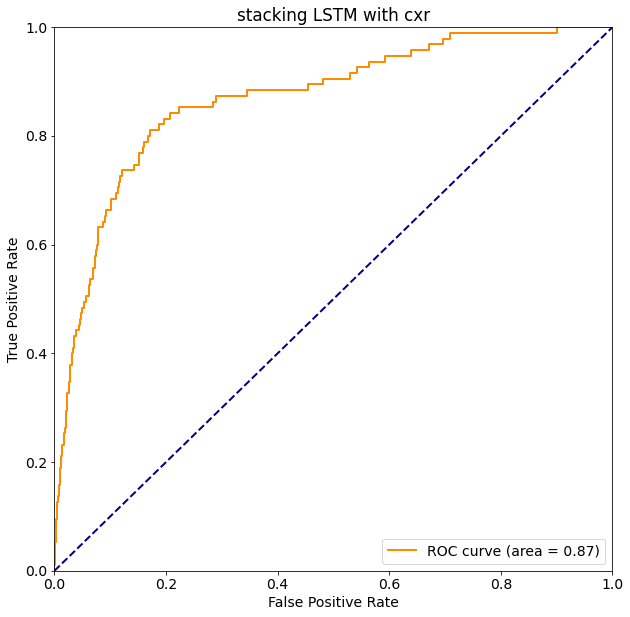

In [145]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()